<a href="https://colab.research.google.com/github/eujin99/SNN-TIL/blob/main/STDP_MNIST_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STDP_MNIST test 1

train acc 51%

In [1]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:00


In [2]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

### 스파이크 이벤트 처리

spiking 뉴런은 시냅스 입력이 시간에 따라 도착하는 스파이크여야 동작함

따라서 고정된 픽셀 강도를 이 뉴런이 얼마나 자주 발화하는지 (Hz) 로 치환해줘야 함

### 밝기 <-> 스파이크 빈도

픽셀이 밝을수록 발화율 증가 : 뉴런이 자주 spike

픽셀이 어두우면 발화율 감소 : 거의 spike 하지 않음

=>> 이미지 패턴이 시간축으로 퍼져서 SNN 에서 처리 가능

In [3]:
from tensorflow.keras.datasets import mnist

# MNIST dataset (0-9)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 픽셀값(0-255)을 발화율(Hz)로 변환 (스케일 축소)
# 최대값 255가 약 63Hz가 되도록 4로 나눔
X_train = X_train / 4
X_test = X_test / 4

# 최종 데이터셋 크기 출력
X_train.shape, X_test.shape


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

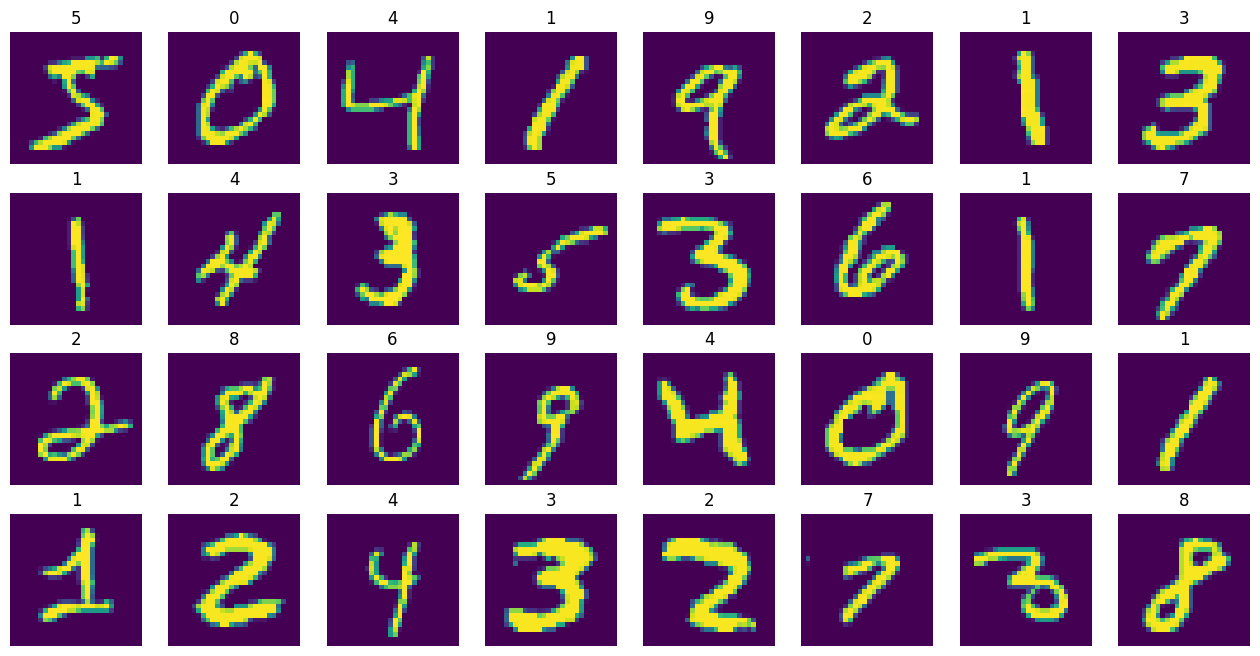

In [4]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [5]:
prefs.codegen.target = 'numpy'      # 기본값(안전)

defaultclock.dt = 0.5*ms

\
n_input = 28*28
n_e = 100
n_i = n_e

v_rest_e, v_reset_e, v_thresh_e = -60.*mV, -65.*mV, -52.*mV
v_rest_i, v_reset_i, v_thresh_i = -60.*mV, -45.*mV, -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre  *= gmax

stdp = '''w : 1
    lr : 1 (shared)
    dApre/dt  = -Apre  / taupre  : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''

pre = '''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''

post = '''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

# ===== 빠른 모드 파라미터 =====
ACTIVE_T  = 0.15*second   # 0.35s → 0.15s
PASSIVE_T = 0.05*second   # 0.15s → 0.05s
RATE_SCALE = (0.35/0.15)  # 시간 줄인 만큼 rate를 키워 총 스파이크량 보정 ≈ 2.333...
CONNECT_P  = 0.35         # 완전연결 → 35% 희소화(연산량↓, 정확도 유지 시도)

class Model():
    def __init__(self, debug=False):
        app = {}

        # 입력: PoissonGroup (초기 0 Hz)
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # 흥분성 뉴런
        neuron_e = '''
            dv/dt  = (ge*(0*mV - v) + gi*(-100*mV - v) + (v_rest_e - v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms)  : 1
            dgi/dt = -gi / (10*ms) : 1
        '''
        app['EG'] = NeuronGroup(
            n_e, neuron_e, threshold='v>v_thresh_e',
            refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG'
        )
        app['EG'].v = v_rest_e - 20.*mV

        # 억제성 뉴런
        neuron_i = '''
            dv/dt  = (ge*(0*mV - v) + (v_rest_i - v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
        '''
        app['IG'] = NeuronGroup(
            n_i, neuron_i, threshold='v>v_thresh_i',
            refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG'
        )
        app['IG'].v = v_rest_i - 20.*mV

        # 입력→흥분성 (STDP, 희소 연결)
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect(p=CONNECT_P)     # ★ 희소화: 연산량 크게 절감
        app['S1'].w = 'rand()*gmax'
        app['S1'].lr = 1                   # 학습 ON

        # 흥분성→억제성 (1:1, 강한 연결)
        app['S2'] = Synapses(app['EG'], app['IG'], 'w:1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3

        # 억제성→흥분성 (자가 제외 전부 억제)
        app['S3'] = Synapses(app['IG'], app['EG'], 'w:1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03

        # (평가 때 재사용할 스파이크 모니터: 하나만 만들고 인덱스 차이로 집계)
        app['SPK_E'] = SpikeMonitor(app['EG'], name='SPK_E')

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    # ----- 빠른 train (rate 스케일링 + 짧은 시간) -----
    def train(self, X, epoch=1):
        self.net['S1'].lr = 1  # STDP ON
        for _ in range(epoch):
            for idx in range(len(X)):
                # Active: 시간 줄인 대신 rate를 키운다
                self.net['PG'].rates = (X[idx].ravel() * RATE_SCALE) * Hz
                self.net.run(ACTIVE_T)

                # Passive: 휴식도 짧게
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(PASSIVE_T)

    # ----- 빠른 evaluate (모니터 재사용) -----
    def evaluate(self, X):
        self.net['S1'].lr = 0  # STDP OFF
        feats = []
        spkmon = self.net['SPK_E']
        for idx in range(len(X)):
            i0 = len(spkmon.i)  # 실행 전 인덱스
            self.net['PG'].rates = (X[idx].ravel()) * Hz
            self.net.run(ACTIVE_T)

            # 이번 샘플의 스파이크만 카운트
            inds = np.array(spkmon.i[i0:])
            counts = np.bincount(inds, minlength=n_e)
            feats.append(counts.astype(np.int16))

            # Passive
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(PASSIVE_T)
        return feats


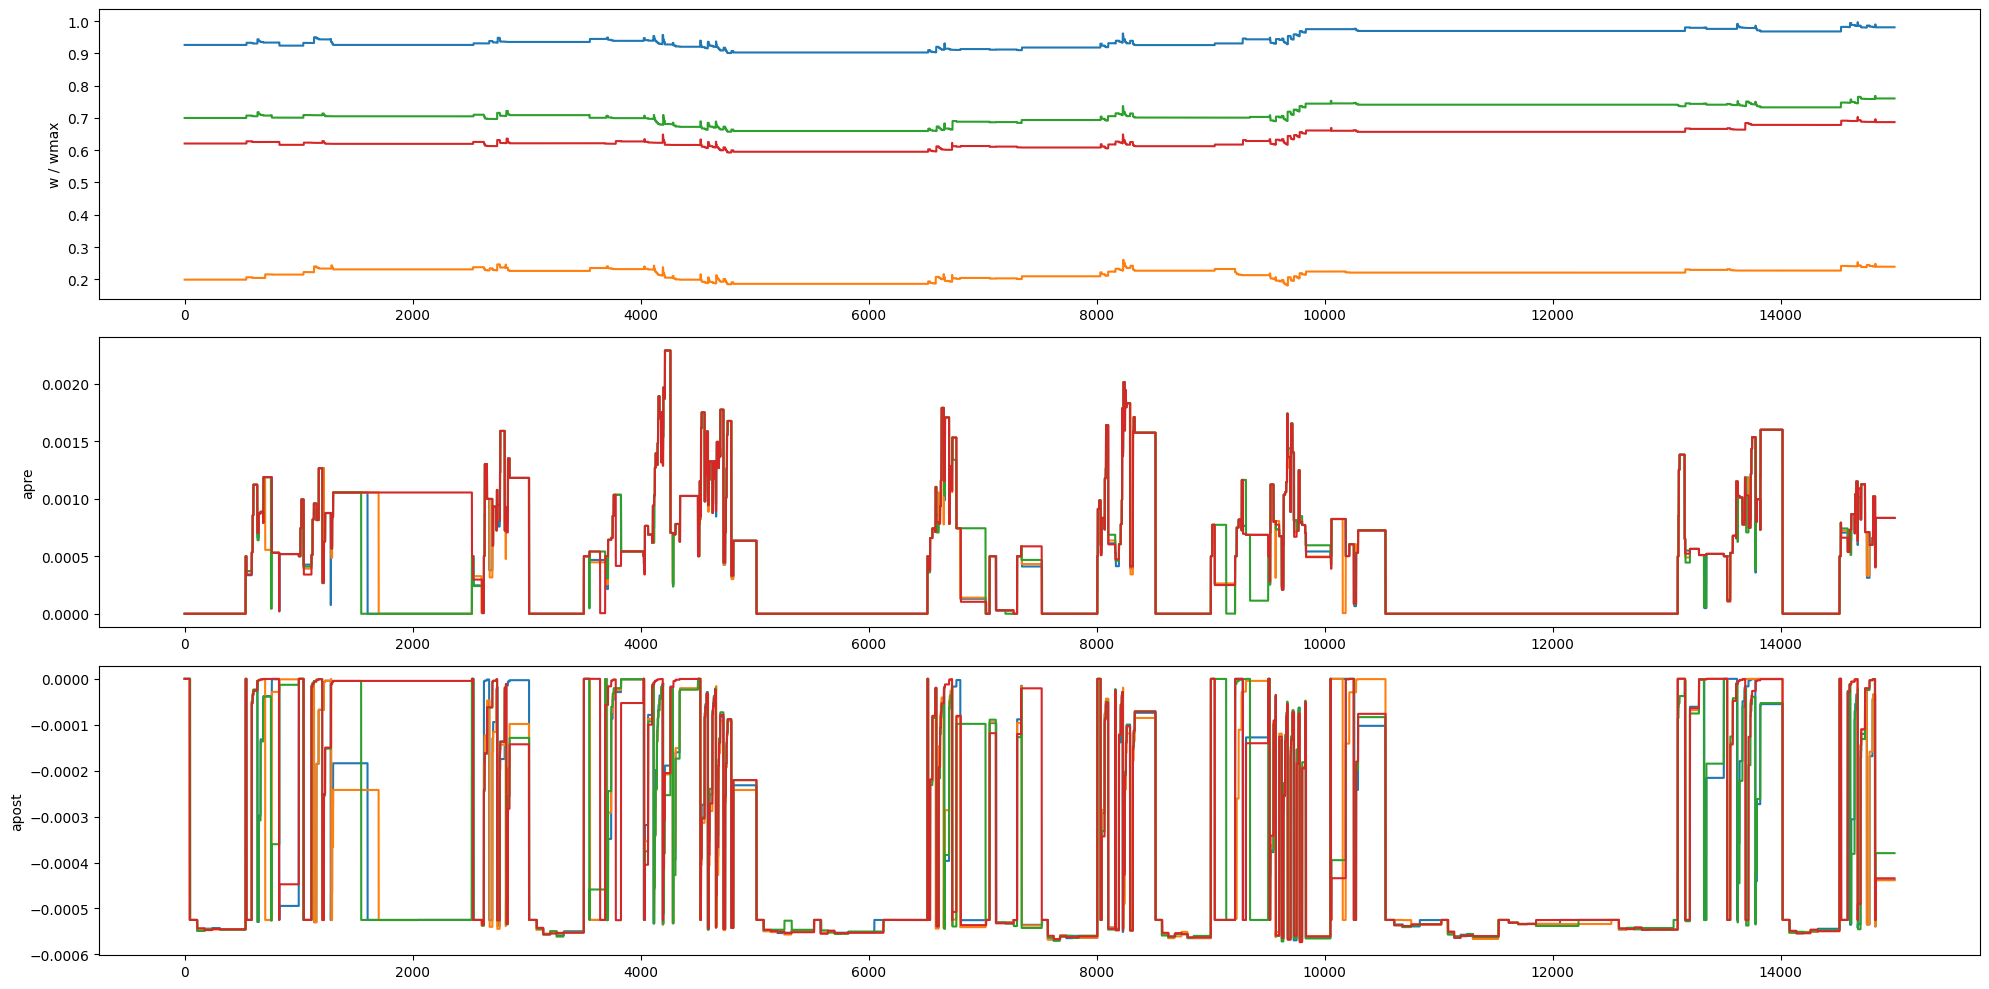

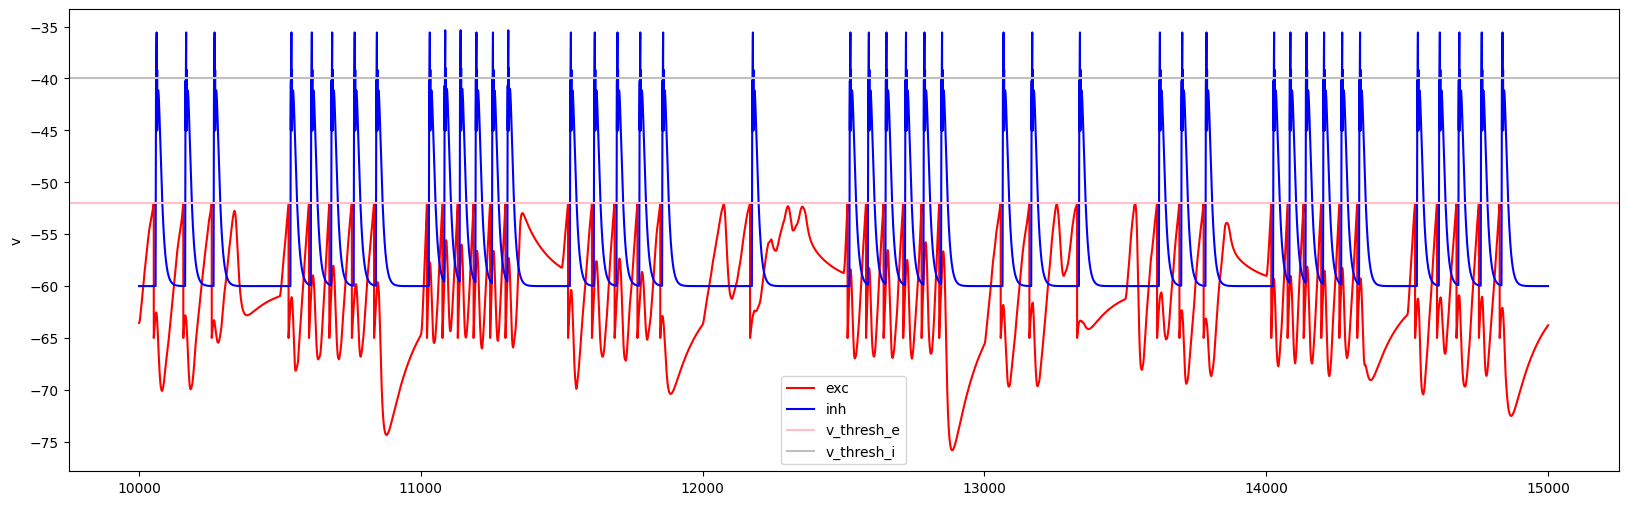

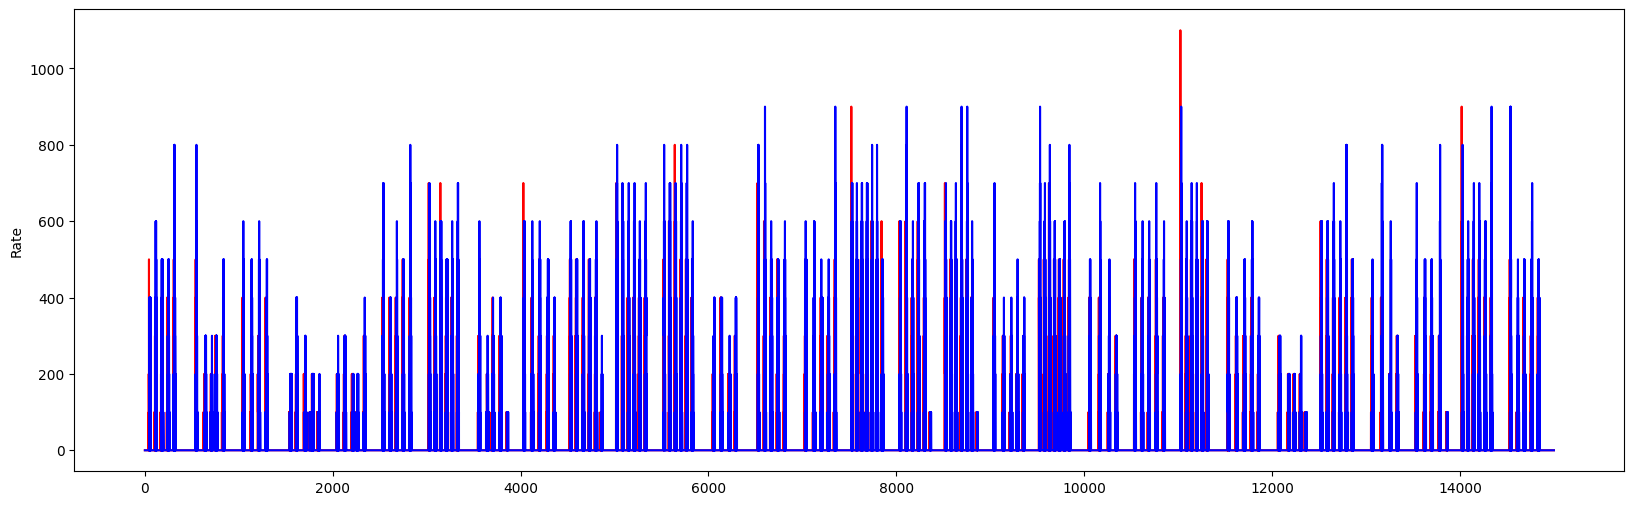

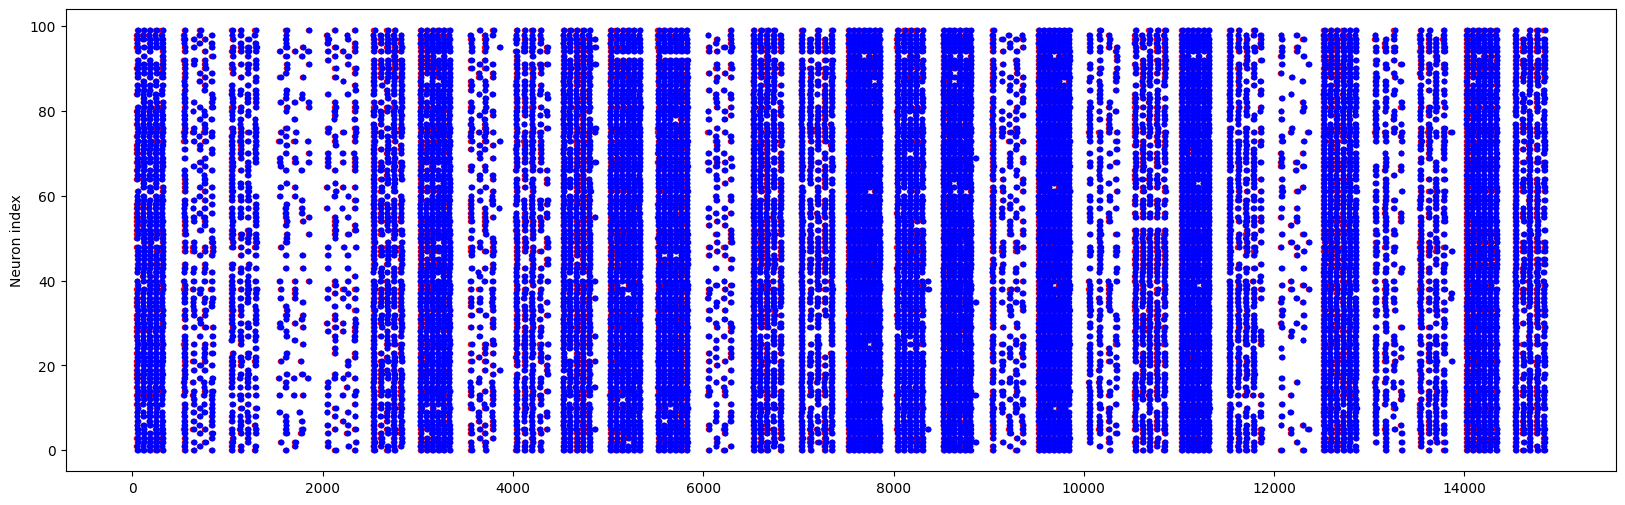

In [8]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();


def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();

def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();

def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)

    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=1)

    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])

test0()

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def train_with_progress(model, X, epoch=1):
    """
    빠른 모드 학습:
    - STDP ON
    - Active/PASSIVE 시간 단축 + RATE_SCALE로 입력 보정
    - tqdm 진행바 표시
    """
    model.net['S1'].lr = 1  # STDP ON
    total = epoch * len(X)
    pbar = tqdm(total=total, desc="STDP train", unit="img")
    for _ in range(epoch):
        for idx in range(len(X)):
            # Active: 시간 줄인 대신 rate를 스케일업
            model.net['PG'].rates = (X[idx].ravel() * RATE_SCALE) * Hz
            model.net.run(ACTIVE_T)

            # Passive: 휴식도 짧게
            model.net['PG'].rates = np.zeros(n_input) * Hz
            model.net.run(PASSIVE_T)

            pbar.update(1)
    pbar.close()

def evaluate_with_progress(model, X, desc="Feature extract"):
    """
    빠른 모드 평가:
    - STDP OFF
    - SpikeMonitor 재사용(SPK_E) 후 '증분'만 집계 → 오버헤드↓
    - Active/PASSIVE 시간 단축 사용
    """
    model.net['S1'].lr = 0  # STDP OFF
    feats = []
    pbar = tqdm(total=len(X), desc=desc, unit="img")

    spkmon = model.net['SPK_E']  # Model.__init__에서 만든 모니터 재사용

    for idx in range(len(X)):
        # 실행 전 인덱스 스냅샷
        i0 = len(spkmon.i)

        # Active
        model.net['PG'].rates = (X[idx].ravel()) * Hz
        model.net.run(ACTIVE_T)

        # 이번 샘플 동안의 스파이크만 카운트
        inds = np.array(spkmon.i[i0:])
        counts = np.bincount(inds, minlength=n_e)
        feats.append(counts.astype(np.int16))

        # Passive
        model.net['PG'].rates = np.zeros(n_input) * Hz
        model.net.run(PASSIVE_T)

        pbar.update(1)
    pbar.close()
    return feats

def test1_progress(train_items=5000, assign_items=1000, eval_items=1000):
    # 시드 고정
    np.random.seed(0)
    random.seed(0)

    model = Model()

    # 1) STDP 학습
    train_with_progress(model, X_train[:train_items], epoch=1)

    # 스냅샷 저장
    model.net.store('train', 'train.b2')

    # 2) 학습 특징 추출
    f_train = evaluate_with_progress(model, X_train[:assign_items], desc="Feat (train)")

    # 3) RandomForest 학습/훈련 정확도
    clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print("Train feature accuracy:", clf.score(f_train, y_train[:assign_items]))

    # 4) 테스트 특징 추출
    f_test = evaluate_with_progress(model, X_test[:eval_items], desc="Feat (test)")

    # 5) 예측/지표
    y_pred = clf.predict(f_test)
    acc = accuracy_score(y_test[:eval_items], y_pred)          # y_true, y_pred 순서
    cm  = confusion_matrix(y_test[:eval_items], y_pred)

    print("Test accuracy:", acc)
    print("Confusion matrix:\n", cm)

# 실행
test1_progress()


STDP train:   0%|          | 0/5000 [00:00<?, ?img/s]

Feat (train):   0%|          | 0/1000 [00:00<?, ?img/s]

Train feature accuracy: 0.513


Feat (test):   0%|          | 0/1000 [00:00<?, ?img/s]